In [3]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import MNIST
from skimage.util import random_noise

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
!pip install torch_summary

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [7]:
device

'cuda'

## 2. Implement a Denoising Autoencoder using three encoding and three decoding
## layers on the MNIST dataset for construction and reconstruction of the
## image. Use MSE as the loss function.


### A. Use 1 FC layer with softmax activation for 10-class classification
### B. Use 2 FC layers with softmax activation for 10-class classification
### C. Compare the performance between 1FC and 2 FC layer results and
### eport the accuracy on test set and plot loss curves on training and test dataset

In [8]:
class Noise:
  def __init__(self,noise_factor):
    self.noise_factor=noise_factor
  def __call__(self, tensor):
    noisy = tensor+torch.randn_like(tensor) * self.noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

In [9]:
img_transform=transforms.Compose([
      transforms.ToTensor(),
      Noise(0.1),
      #transforms.Normalize([0.5],[0.5]),
      #transforms.Lambda(lambda x:x.to(device))
])

In [10]:
img_transform3=transforms.Compose([
      transforms.ToTensor(),
      Noise(0.1),
      #transforms.Normalize([0.5],[0.5]),
      #transforms.Lambda(lambda x:x.to(device))
])

In [11]:
img_transform2=transforms.Compose([
      transforms.ToTensor(),
      #transforms.Normalize([0.5],[0.5]),
      transforms.Lambda(lambda x:x.to(device))
])

In [12]:
train_dataset=MNIST("/content/",transform=img_transform3,train=True,download=True)
test_dataset=MNIST("/content/",transform=img_transform,train=False,download=True)

In [13]:
batch_size=256
train_dl=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
test_dl=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [14]:
train_dataset_wn=MNIST("/content/",transform=img_transform2,train=True,download=True)
train_dl_without_noise=torch.utils.data.DataLoader(train_dataset_wn,batch_size=batch_size,shuffle=False)

In [15]:
data=iter(train_dl)
data2=iter(train_dl_without_noise)

In [16]:
img_n,labels=data.next()
img_wn,labels=data2.next()

In [17]:
img_n.shape

torch.Size([256, 1, 28, 28])

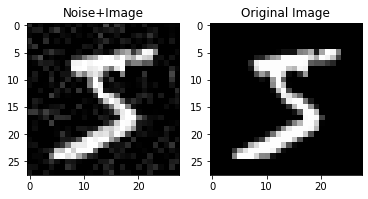

In [18]:
plt.subplot(1,2,1)
plt.title("Noise+Image")
plt.imshow(img_n[0][0].cpu(),cmap="gray")
plt.subplot(1,2,2)
plt.title("Original Image")
plt.imshow(img_wn[0][0].cpu(),cmap="gray")

In [19]:
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    #self.latent_dim=latent_dim
    self.encoder=nn.Sequential(
        nn.Conv2d(1,32,3,stride=1,padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(2,stride=1),
        nn.Conv2d(32,64,3,stride=1,padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(2,stride=1),
        nn.Conv2d(64,128,3),
        nn.MaxPool2d(2,stride=1),
        nn.ReLU(True)
    )
    self.decoder=nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3,stride=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 32, 5,stride=1),
        nn.ReLU(True),
        #nn.ConvTranspose2d(32, 16, 2,stride=1,padding=1),
        #nn.ReLU(True),
        nn.ConvTranspose2d(32, 1, 2,stride=1,padding=1),
        nn.Tanh()
    )
  def forward(self,x):
      x=self.encoder(x)
      x=self.decoder(x)
      return x

In [51]:
from torchsummary import summary
model = autoencoder().to(device)
#summary(model, torch.zeros(2,1,28,28))

In [52]:
criterion=nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [20]:
def calculate_accuracy(org,pred):
  acc=0.0
  tot=0.0
  for i in range(len(pred)):
    tot+=1
    if org[i]==pred[i]:
      acc+=1
  return(acc/tot)

In [124]:

def training_model():

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model=autoencoder().to(device)
  criterion=nn.MSELoss()
  optimizer=torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
  noise_factor=0.1

  train_dataset=MNIST("/content/",transform=img_transform,train=True,download=True)
  test_dataset=MNIST("/content/",transform=img_transform,train=False,download=True)

  batch_size=2000
  train_dl=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
  test_dl=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
  n_steps=len(train_dataset)
  no_iter=n_steps//batch_size

  epochs=5
  print(n_steps,no_iter)

  
  #accuracy_data=[]
  loss_data=[]
  #test_accuracy_data=[]
  test_loss_data=[]

  for i in range(epochs):
    for it in range(no_iter):
      for j,(input,labels) in enumerate(train_dl):
        noisy = input+torch.randn_like(input) * noise_factor
        noisy = torch.clip(noisy,0.,1.)

        input,noisy=input.to(device),noisy.to(device)
        outputs=model(noisy)
        outputs.to(device)
        loss=criterion(outputs,input)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #acc=calculate_accuracy(labels,torch.argmax(outputs,dim=-1))
        #accuracy_data.append(acc)
        loss_data.append(loss.item())
    
    print("EPOCHS: ",i+1,"LOSS VALUE: ",loss.item())

      
    for j,(input,labels) in enumerate(test_dl):
      with torch.no_grad():
        noisy = input+torch.randn_like(input) * noise_factor
        noisy = torch.clip(noisy,0.,1.)

        noisy,input=noisy.to(device),input.to(device)
        outputs=model(noisy)
        outputs.to(device)
        loss=criterion(outputs,input)

          #acc=calculate_accuracy(labels,torch.argmax(outputs,dim=-1))
          #test_accuracy_data.append(acc)
        test_loss_data.append(loss.item())
    
      print("EPOCHS: ",i+1,"LOSS VALUE TEST DATA: ",loss.item())

  return(model,loss_data,test_loss_data)

In [ ]:
a,b,c=training_model()

60000 30
EPOCHS:  1 LOSS VALUE:  0.006467664614319801
EPOCHS:  1 LOSS VALUE TEST DATA:  0.006339996121823788
EPOCHS:  1 LOSS VALUE TEST DATA:  0.006354067008942366
EPOCHS:  1 LOSS VALUE TEST DATA:  0.006313418969511986
EPOCHS:  1 LOSS VALUE TEST DATA:  0.006323549430817366
EPOCHS:  1 LOSS VALUE TEST DATA:  0.006367472466081381
EPOCHS:  2 LOSS VALUE:  0.005716713145375252
EPOCHS:  2 LOSS VALUE TEST DATA:  0.005606105551123619
EPOCHS:  2 LOSS VALUE TEST DATA:  0.005628070328384638
EPOCHS:  2 LOSS VALUE TEST DATA:  0.00564557546749711
EPOCHS:  2 LOSS VALUE TEST DATA:  0.005594777874648571
EPOCHS:  2 LOSS VALUE TEST DATA:  0.005621206481009722
EPOCHS:  3 LOSS VALUE:  0.005382813513278961
EPOCHS:  3 LOSS VALUE TEST DATA:  0.005284422542899847
EPOCHS:  3 LOSS VALUE TEST DATA:  0.0052993884310126305
EPOCHS:  3 LOSS VALUE TEST DATA:  0.005258145742118359
EPOCHS:  3 LOSS VALUE TEST DATA:  0.005276924464851618
EPOCHS:  3 LOSS VALUE TEST DATA:  0.0052633280865848064
EPOCHS:  4 LOSS VALUE:  0.0051

In [1]:
torch.save(a.state_dict(),"model_weights")

In [24]:
test_data=iter(test_dl)
img,labels=test_data.next()

In [25]:
img.shape

torch.Size([256, 1, 28, 28])

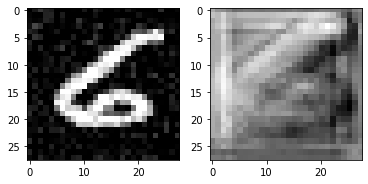

In [82]:
plt.subplot(1,2,1)
plt.imshow(img[2][0].cpu(),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(model(img)[2][0].cpu().detach().numpy(),cmap="gray")

In [21]:
!nvidia-smi

Sun Feb 13 08:19:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    74W / 149W |    519MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
device="cpu"

In [22]:
model = autoencoder().to(device)
model.load_state_dict(torch.load("model_weights"))
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
  )
)

In [26]:
#img=img.to("cuda");
o=model(img)

Text(0.5, 0.98, 'Denoising Convolutional Autoencoder')

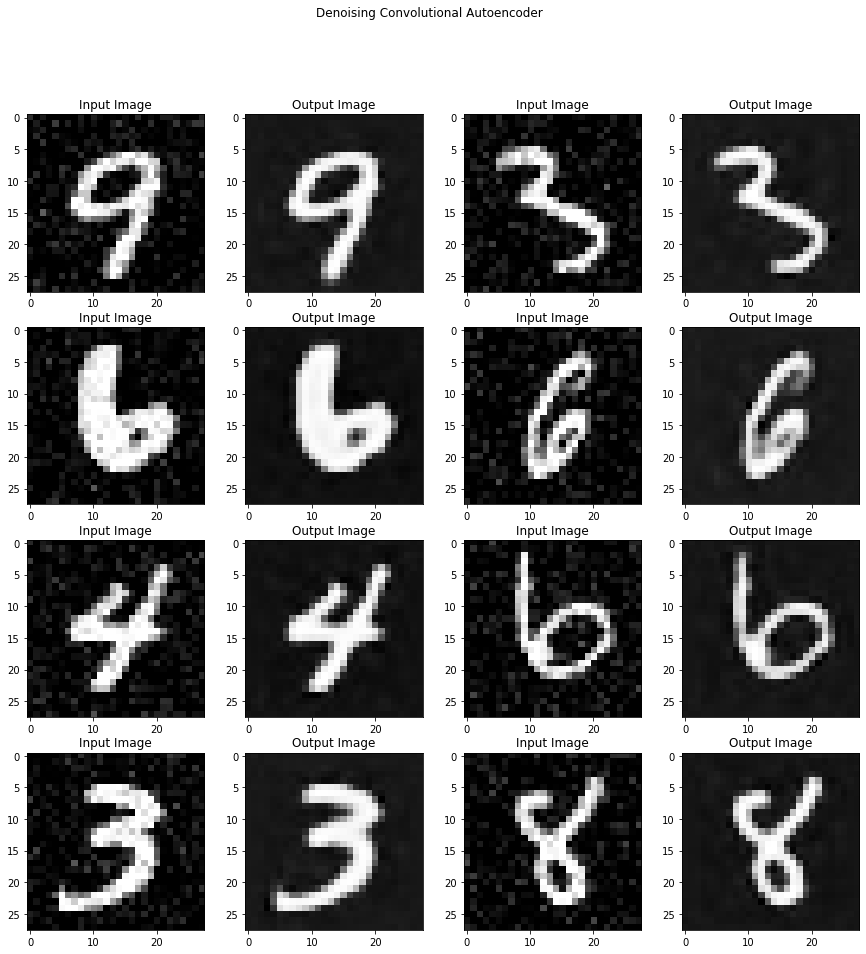

In [27]:
import random
plt.figure(figsize=(15,15))
for i in range(1,16,2):
    r=random.randint(0,255)
    plt.subplot(4,4,i)
    plt.title("Input Image")
    plt.imshow(img[r][0].cpu(),cmap="gray")
    plt.subplot(4,4,i+1)
    plt.title("Output Image")
    plt.imshow(o[r][0].cpu().detach().numpy(),cmap="gray")
plt.suptitle("Denoising Convolutional Autoencoder")

In [28]:
class NeuralNetwork1(nn.Module):
  def __init__(self):
    super(NeuralNetwork1,self).__init__()
    self.fc1=nn.Linear(67712,10)
  def forward(self,x):
    latent_vector=model.encoder(x).view(len(x),-1)
    o=self.fc1(latent_vector)
    return o

In [29]:
class NeuralNetwork2(nn.Module):
  def __init__(self):
    super(NeuralNetwork2,self).__init__()
    self.fc1=nn.Linear(67712,50)
    self.fc2=nn.Linear(50,10)
  def forward(self,x):
    latent_vector=model.encoder(x).view(len(x),-1)
    o=self.fc1(latent_vector)
    o=self.fc2(o)
    return o

In [50]:
model.to("cpu")

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
  )
)

In [30]:
from torch.nn.modules.loss import CrossEntropyLoss

def training_fc_model(model):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  device="cpu"
  criterion=CrossEntropyLoss()
  optimizer=torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
  noise_factor=0.1

  train_dataset=MNIST("/content/",transform=img_transform,train=True,download=True)
  test_dataset=MNIST("/content/",transform=img_transform,train=False,download=True)

  batch_size=3000
  train_dl=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
  test_dl=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
  n_steps=len(train_dataset)
  no_iter=n_steps//batch_size

  epochs=1
  print(n_steps,no_iter)

  
  accuracy_data=[]
  loss_data=[]
  test_accuracy_data=[]
  test_loss_data=[]


  for i in range(epochs):
    for it in range(no_iter):
      for j,(input,labels) in enumerate(train_dl):

        noisy = input+torch.randn_like(input) * noise_factor
        noisy = torch.clip(noisy,0.,1.)

        noisy,labels=noisy.to(device),labels.to(device)
        outputs=model(noisy)
        outputs.to(device)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc=calculate_accuracy(labels,torch.argmax(outputs,dim=-1))
        accuracy_data.append(acc)
        loss_data.append(loss.item())
    
      print("EPOCHS:",i+1," Iteration:",it+1," LOSS VALUE TRAIN DATA:",loss.item()," ACCURACY TRAIN DATA: ",acc)

      
      for j,(input,labels) in enumerate(test_dl):
        with torch.no_grad():
          noisy = input+torch.randn_like(input) * noise_factor
          noisy = torch.clip(noisy,0.,1.)

          noisy,labels=noisy.to(device),labels.to(device)
          outputs=model(noisy)
          outputs.to(device)

          loss=criterion(outputs,labels)
          acc=calculate_accuracy(labels,torch.argmax(outputs,dim=-1))
          test_accuracy_data.append(acc)
          test_loss_data.append(loss.item())
    
      print("EPOCHS: ",i+1,"Iteration: ",it+1,"LOSS VALUE TEST DATA: ",loss.item(),"ACCURACY TEST DATA: ",acc)

  return(accuracy_data,loss_data,test_accuracy_data,test_loss_data)

In [31]:
a,b,c,d=training_fc_model(NeuralNetwork1())

60000 20
EPOCHS: 1  Iteration: 1  LOSS VALUE TRAIN DATA: 0.520369291305542  ACCURACY TRAIN DATA:  0.897
EPOCHS:  1 Iteration:  1 LOSS VALUE TEST DATA:  0.5936489105224609 ACCURACY TEST DATA:  0.844


KeyboardInterrupt: ignored

In [ ]:
a1,b1,c1,d1=training_fc_model(NeuralNetwork2())